In [1]:
import sys
# load standard python modules
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score

from sklearn.metrics import roc_curve

plt.style.use("science.mplstyle")

from matplotlib.backends.backend_pdf import PdfPages




# load custom modules required for jetCLR training
from modules.jet_augs import apply_single_jet_augs, translate_jets, rotate_jets, rescale_pts, distort_jets, collinear_fill_jets, crop_jets
from modules.jet_augs import shift_eta, shift_phi
from modules.perf_eval import get_perf_stats, linear_classifier_test, plot_losses
from modules.jet_visualizers import plot_jets_phase_plane, plot_nsubs, plot_mj, plot_mjj


# Load in the processed data

In [2]:
path_to_save_dir = "/global/home/users/rrmastandrea/training_data_vf/"


save_id_dir = "nBC_sig_10000_nBC_bkg_10000_n_nonzero_50_n_pad_0_n_jet_2/"

grading = 50

path_to_data = path_to_save_dir+save_id_dir
print(path_to_data)


#clr_train = np.load(path_to_data+"clr_train.npy")
#clr_val = np.load(path_to_data+"clr_val.npy")
data_train = np.load(path_to_data+"data_train.npy")
labels_train = np.load(path_to_data+"labels_train.npy")
data_val = np.load(path_to_data+"data_val.npy")
labels_val = np.load(path_to_data+"labels_val.npy")
#data_test_f = np.load(path_to_data+"data_test_f.npy")
#labels_test_f = np.load(path_to_data+"labels_test_f.npy")

# print data dimensions
#print( "CLR training data shape: " + str( clr_train.shape ), flush=True)
#print( "CLR val data shape: " + str( clr_val.shape ), flush=True)
print( "BC training data shape: " + str( data_train.shape ), flush=True)
print( "BC training labels shape: " + str( labels_train.shape ), flush=True)
print( "BC val data shape: " + str( data_val.shape ), flush=True)
print( "BC val labels shape: " + str( labels_val.shape ), flush=True)
#print( "BC test data shape: " + str( data_test_f.shape ), flush=True)
#print( "BC test labels shape: " + str( labels_test_f.shape ), flush=True)


# Plot num constituents

def get_num_constits(dataset):
    consits_list = []
    for collision in dataset:
        pts = collision[0,:]

        pads = np.where(pts==0)
        consits_list.append(dataset.shape[2]-len(pads[0]))
        
    return consits_list
        

/global/home/users/rrmastandrea/training_data_vf/nBC_sig_10000_nBC_bkg_10000_n_nonzero_50_n_pad_0_n_jet_2/
BC training data shape: (14000, 3, 102)
BC training labels shape: (14000,)
BC val data shape: (6000, 3, 102)
BC val labels shape: (6000,)


# Plot the jet constituents next to the augmented versions

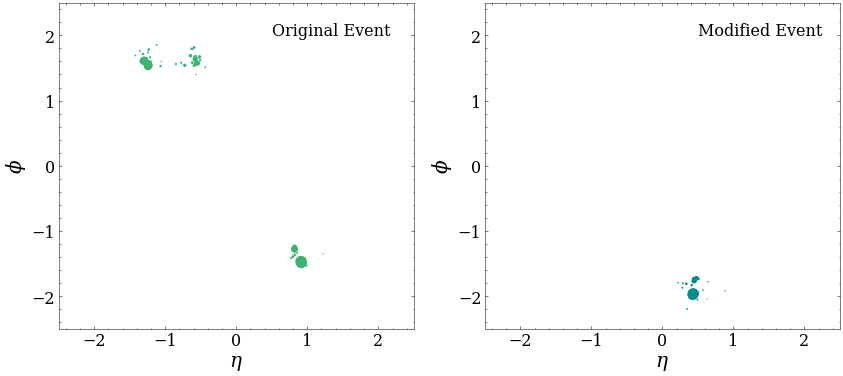

In [32]:
#path_to_data_storage = "/clusterfs/ml4hep/rrmastandrea/processed_data/"+"dijet"+"/"

#high_mass_consits_wjet_deltaJ1 = np.load(path_to_data_storage+"50_jets_J1_pi_2.npy")

max_pt = np.max(data_val[0][0])

ptcm = 5*max_pt

rot = True
trs = True
trsw = .5
dis = True
ptst = .1
col = True
ptcm = .1

np.random.seed(0)



orig_events, mod_events = apply_single_jet_augs(data_val, 2, "J1_phi_only_pi_2", rot, trs, dis, col)


mod_events = shift_phi(mod_events)
mod_events = shift_eta(mod_events)




for index_to_plot in range(5,6):
 
    fig = plot_jets_phase_plane(orig_events[index_to_plot], mod_events[index_to_plot], .5, xlims=(-2.5,2.5), ylims=(-2.5,2.5))

    
img_name = "figures/phase_plane.pdf"
pp = PdfPages(img_name)
pp.savefig(fig)
pp.close()



# Plot nsubjettiness

In [33]:
# calculate n sub jettiness

# split the list of events into a larger list of jets

#orig_events_long = np.concatenate(np.split(orig_events, 2, axis = 2), axis = 0)
#mod_events_long = np.concatenate(np.split(mod_events, 2, axis = 2), axis = 0)

orig_events_hardest = np.split(orig_events, 2, axis = 2)[0]
orig_events_second = np.split(orig_events, 2, axis = 2)[1]
mod_events_hardest = np.split(mod_events, 2, axis = 2)[0]
mod_events_second = np.split(mod_events, 2, axis = 2)[1]

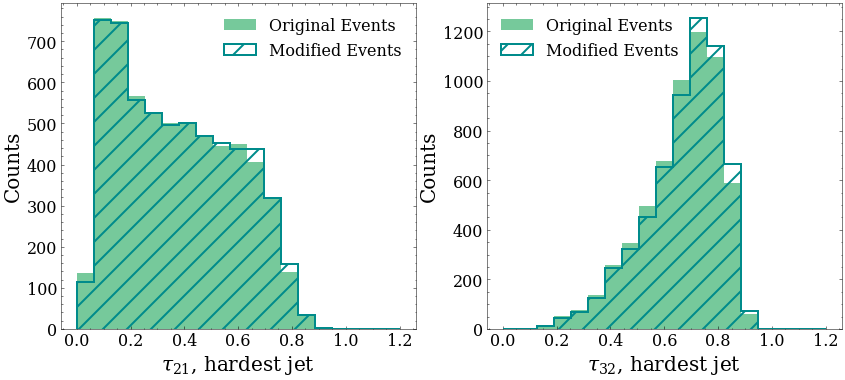

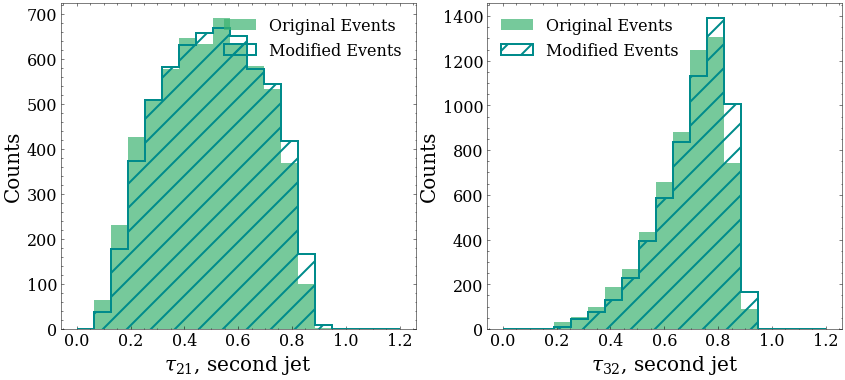

In [34]:
plot_nsubs(orig_events_hardest,mod_events_hardest,title=", hardest jet")
plot_nsubs(orig_events_second,mod_events_second,title=", second jet")


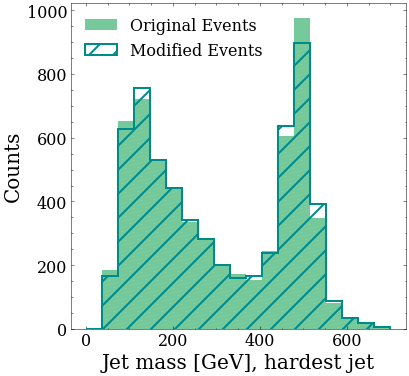

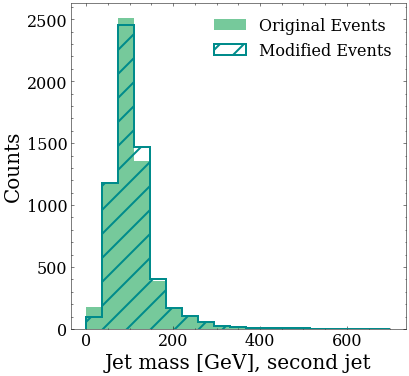

In [35]:
fig = plot_mj(orig_events_hardest,mod_events_hardest, title=", hardest jet")

img_name = "hardest_jet_mass.pdf"
pp = PdfPages(img_name)
pp.savefig(fig)
pp.close()



fig = plot_mj(orig_events_second,mod_events_second, title=", second jet")

img_name = "second_jet_mass.pdf"
pp = PdfPages(img_name)
pp.savefig(fig)
pp.close()


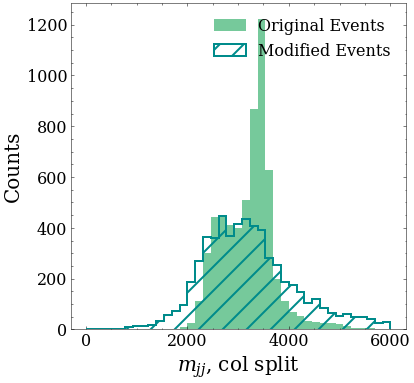

In [36]:
fig = plot_mjj(orig_events_hardest, orig_events_second, mod_events_hardest, mod_events_second, bins = np.linspace(0,6000,40), title = ", col split")



img_name = "mjj.pdf"
pp = PdfPages(img_name)
pp.savefig(fig)
pp.close()

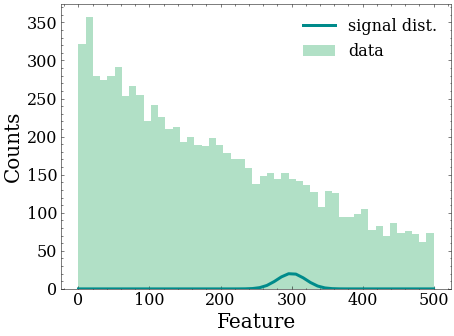

In [37]:
# plot for poster
import scipy.stats as stats

n_sig = 100
n_bkg = 10000

signal_mean = 300
signal_sigma = 20
background = np.random.exponential(scale=300.0, size=n_bkg)
signal = np.random.normal(signal_mean,signal_sigma,n_sig)

total = np.concatenate((signal,background))
    
bins = np.linspace(0,500,50)
plt.hist(total, bins, alpha = .4, color = "mediumseagreen", label="data")
plt.plot(bins, (n_sig*(bins[1]-bins[0]))*stats.norm.pdf(bins, signal_mean, signal_sigma), 
         color = "darkcyan", label = "signal dist.", linewidth = 3)
plt.xlabel("Feature")
plt.ylabel("Counts")
plt.legend()
